# **Seq2Seq with Luong (Global) Attention**

## **From Scratch Implementation in NumPy**

This notebook builds upon the standard Encoder-Decoder architecture by implementing **Luong Attention** (specifically the **Global Attention** mechanism with the **General** scoring function) [Luong et al., 2015].


### **Why Luong Attention?**
While Bahdanau Attention (Additive) was the breakthrough, Luong Attention simplified the architecture and introduced different ways to calculate the alignment scores.

**Key Differences from Bahdanau:**
1.  **Computation Path (Update $\rightarrow$ Look):**
    - **Bahdanau:** The decoder looks at the source *before* updating its hidden state ($s_{t-1} \rightarrow \text{Attention} \rightarrow s_t$).
    - **Luong:** The decoder updates its hidden state first, *then* looks at the source ($s_{t-1} \rightarrow s_t \rightarrow \text{Attention}$).
2.  **Scoring Functions:** Luong proposed three ways to calculate energy:
    - **Dot:** $s_t^T h_i$
    - **General:** $s_t^T \mathbf{W}_a h_i$ (We implement this one)
    - **Concat:** $\mathbf{v}^T \tanh(\mathbf{W}[s_t; h_i])$
3.  **Attentional Vector ($\tilde{h}_t$):** Luong introduces a specific "context" layer after attention to combine the context and hidden state before prediction.

---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025* <br>
*License: MIT*

In [1]:
import re
import random
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [2]:
data = open('../data/thirsty_crow_v2.txt', 'r').read().lower()
sentences = re.split(r'(?<=[.!?])\s+', data)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
print(f"Found {len(sentences)} sentences.")
print(f"Example sentences: {sentences[:2]}")

Found 37 sentences.
Example sentences: ['the crow was thirsty .', 'a bird was very dry .']


In [3]:
#Build Vocab
words = []
for sent in sentences:
    word = re.findall(r"\w+|[.,!?'\";:]", sent)
    words.extend(word)

SOS_TOKEN = '<SOS>'  # Start of Sequence
EOS_TOKEN = '<EOS>'  # End of Sequence
UNK_TOKEN = '<UNK>'  # Unknown word

vocab = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(list(set(words)))
vocab_size = len(vocab)
word_to_ix = {w: i for i, w in enumerate(vocab)}
ix_to_word = {i: w for i, w in enumerate(vocab)}

print(f"Vocab Size: {vocab_size}")

Vocab Size: 82


In [4]:
#Create Training Pairs (Encoder(Input), Decoder(Target))  with Teacher Forcing
training_pairs = []

for i in range(len(sentences) - 1):
    src_text = sentences[i]
    src_words = re.findall(r"\w+|[.,!?'\";:]", src_text)
    src_indices = [word_to_ix[w] for w in src_words]

    trg_text = sentences[i+1]
    trg_words = re.findall(r"\w+|[.,!?'\";:]", trg_text)

    dec_input = [word_to_ix[SOS_TOKEN]] + [word_to_ix[w] for w in trg_words] # Decoder Input: <SOS> + sentence
    dec_target = [word_to_ix[w] for w in trg_words] + [word_to_ix[EOS_TOKEN]] # Decoder Target: sentence + <EOS>

    training_pairs.append({
        'src': src_indices,
        'dec_input': dec_input,
        'dec_target': dec_target
    })

print(f"\nExample Pair 0:")
print(f"Encoder Input (Indices): {training_pairs[0]['src']}")
print(f"Decoder Input (Indices): {training_pairs[0]['dec_input']}")
print(f"Decoder Target (Indices): {training_pairs[0]['dec_target']}")
print(f"Original Source: {sentences[0]}")
print(f"Original Target: {sentences[1]}")


Example Pair 0:
Encoder Input (Indices): [65, 17, 78, 69, 3]
Decoder Input (Indices): [0, 4, 10, 78, 77, 22, 3]
Decoder Target (Indices): [4, 10, 78, 77, 22, 3, 1]
Original Source: the crow was thirsty .
Original Target: a bird was very dry .


### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3            # Learning rate
hidden_size = 100    # Size of hidden state (h)
embed_size = 100      # Size of embedding vector (e)
MAX_LEN = 25         # Max length for generation
clip_value = 5.0     # Gradient clipping threshold

### __MODEL PARAMETER INITIALIZATION__

Weights for the Encoder, the Decoder, and the specific **Luong General** attention components initialized with **Xavier Initialization** .

**1. Shared Embeddings:**
- $\mathbf{W}_{emb} \in \mathbb{R}^{V \times E}$: Shared lookup table.

**2. Encoder Parameters:**
- Standard GRU weights ($\mathbf{W}^{enc}_u, \mathbf{W}^{enc}_r, \mathbf{W}^{enc}_h$) and biases.

**3. Attention Parameters (Luong General):**
We use the **General** score function, which requires a learnable weight matrix to align source and target states.
- $\mathbf{W}_a \in \mathbb{R}^{H \times H}$: The alignment matrix.
- *Note: Unlike Bahdanau, we do not need $\mathbf{U}_a$ or $\mathbf{v}_a$.*


**4. The Bridge:**
- $\mathbf{W}_{bridge}$: Translates Encoder final state to Decoder initial state.

**5. Decoder Parameters (Standard GRU):**
In Luong attention, the GRU input is **only** the word embedding.
- $\mathbf{W}^{dec} \in \mathbb{R}^{H \times (H+E)}$: Input size is significantly smaller than Bahdanau (which was $2H+E$).

**6. Luong "Concat" Layer (Attentional Vector):**
This is the signature of Luong Attention. It combines the context vector and the decoder state.
- $\mathbf{W}_c \in \mathbb{R}^{H \times 2H}$: Projects the concatenated $[c_t; s_t]$ back to hidden size.
- $\mathbf{b}_c \in \mathbb{R}^{H \times 1}$: Bias.

**7. Output Layer:**
- $\mathbf{W}_y \in \mathbb{R}^{V \times H}$: Projects the **Attentional Vector** ($\tilde{h}_t$) to vocabulary.

In [6]:
# 1. Shared Embeddings
Wemb = np.random.randn(vocab_size, embed_size) * np.sqrt(2.0 / (vocab_size + embed_size))

# 2. Encoder Parameters
enc_scale = np.sqrt(2.0 / (hidden_size + embed_size + hidden_size))
Wu_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
Wr_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
Wh_enc = np.random.randn(hidden_size, hidden_size + embed_size) * enc_scale
bu_enc = np.zeros((hidden_size, 1))
br_enc = np.zeros((hidden_size, 1))
bh_enc = np.zeros((hidden_size, 1))

# 3. Attention Parameters (The Fix for Collapse)
Wa = np.random.randn(hidden_size, hidden_size) * np.sqrt(1.0 / hidden_size)

# 4. Bridge Parameters
W_bridge = np.random.randn(hidden_size, hidden_size) * np.sqrt(1.0 / hidden_size)
b_bridge = np.zeros((hidden_size, 1))

# 5. Decoder Parameters
dec_scale = np.sqrt(2.0 / (hidden_size + embed_size + hidden_size))
Wu_dec = np.random.randn(hidden_size, hidden_size + embed_size) * dec_scale
Wr_dec = np.random.randn(hidden_size, hidden_size + embed_size) * dec_scale
Wh_dec = np.random.randn(hidden_size, hidden_size + embed_size) * dec_scale
bu_dec = np.zeros((hidden_size, 1))
br_dec = np.zeros((hidden_size, 1))
bh_dec = np.zeros((hidden_size, 1))

# 6. Luong "Concat" Layer
Wc = np.random.randn(hidden_size, 2 * hidden_size) * np.sqrt(2.0 / (3 * hidden_size))
bc = np.zeros((hidden_size, 1))

# 7. Output Layer
Wy = np.random.randn(vocab_size, hidden_size) * np.sqrt(2.0 / (hidden_size + vocab_size))
by = np.zeros((vocab_size, 1))

In [7]:
print(f"""
Wemb: Word Embeddings        : {Wemb.shape}
=========================================
         ENCODER PARAMS
=========================================
Wu_enc: Update Gate Weights  : {Wu_enc.shape}
Wr_enc: Reset Gate Weights   : {Wr_enc.shape}
Wh_enc: CHS Weights          : {Wh_enc.shape}
bu_enc: Update Gate bias     : {bu_enc.shape}
br_enc: Reset Gate bias      : {br_enc.shape}
bh_enc: CHS bias             : {bh_enc.shape}
=========================================
         ATTENTION PARAMS
=========================================
Wa: General Score Weights    : {Wa.shape}
=========================================
         BRIDGE PARAMS
=========================================
W_bridge: Bridge Weights     : {W_bridge.shape}
b_bridge: Bridge bias        : {b_bridge.shape}
=========================================
         DECODER PARAMS
=========================================
Wu_dec: Update Gate Weights  : {Wu_dec.shape}
Wr_dec: Reset Gate Weights   : {Wr_dec.shape}
Wh_dec: CHS Weights          : {Wh_dec.shape}
bu_dec: Update Gate bias     : {bu_dec.shape}
br_dec: Reset Gate bias      : {br_dec.shape}
bh_dec: CHS bias             : {bh_dec.shape}
=========================================
         LUONG CONCAT LAYER
=========================================
Wc: Concat Weights           : {Wc.shape}
bc: Concat bias              : {bc.shape}
=========================================
Wy: Prediction Weights       : {Wy.shape}
by: Prediction bias          : {by.shape}
""")


Wemb: Word Embeddings        : (82, 100)
         ENCODER PARAMS
Wu_enc: Update Gate Weights  : (100, 200)
Wr_enc: Reset Gate Weights   : (100, 200)
Wh_enc: CHS Weights          : (100, 200)
bu_enc: Update Gate bias     : (100, 1)
br_enc: Reset Gate bias      : (100, 1)
bh_enc: CHS bias             : (100, 1)
         ATTENTION PARAMS 
Wa: General Score Weights    : (100, 100)
         BRIDGE PARAMS
W_bridge: Bridge Weights     : (100, 100)
b_bridge: Bridge bias        : (100, 1)
         DECODER PARAMS
Wu_dec: Update Gate Weights  : (100, 200)
Wr_dec: Reset Gate Weights   : (100, 200)
Wh_dec: CHS Weights          : (100, 200)
bu_dec: Update Gate bias     : (100, 1)
br_dec: Reset Gate bias      : (100, 1)
bh_dec: CHS bias             : (100, 1)
         LUONG CONCAT LAYER 
Wc: Concat Weights           : (100, 200)
bc: Concat bias              : (100, 1)
Wy: Prediction Weights       : (82, 100)
by: Prediction bias          : (82, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# 1. Embeddings
mWemb = np.zeros_like(Wemb); vWemb = np.zeros_like(Wemb)

# 2. Encoder
mWu_enc = np.zeros_like(Wu_enc); vWu_enc = np.zeros_like(Wu_enc)
mWr_enc = np.zeros_like(Wr_enc); vWr_enc = np.zeros_like(Wr_enc)
mWh_enc = np.zeros_like(Wh_enc); vWh_enc = np.zeros_like(Wh_enc)
mbu_enc = np.zeros_like(bu_enc); vbu_enc = np.zeros_like(bu_enc)
mbr_enc = np.zeros_like(br_enc); vbr_enc = np.zeros_like(br_enc)
mbh_enc = np.zeros_like(bh_enc); vbh_enc = np.zeros_like(bh_enc)

# 3. Attention (Luong General)
mWa = np.zeros_like(Wa); vWa = np.zeros_like(Wa)

# 4. Bridge
mW_bridge = np.zeros_like(W_bridge); vW_bridge = np.zeros_like(W_bridge)
mb_bridge = np.zeros_like(b_bridge); vb_bridge = np.zeros_like(b_bridge)

# 5. Decoder
mWu_dec = np.zeros_like(Wu_dec); vWu_dec = np.zeros_like(Wu_dec)
mWr_dec = np.zeros_like(Wr_dec); vWr_dec = np.zeros_like(Wr_dec)
mWh_dec = np.zeros_like(Wh_dec); vWh_dec = np.zeros_like(Wh_dec)
mbu_dec = np.zeros_like(bu_dec); vbu_dec = np.zeros_like(bu_dec)
mbr_dec = np.zeros_like(br_dec); vbr_dec = np.zeros_like(br_dec)
mbh_dec = np.zeros_like(bh_dec); vbh_dec = np.zeros_like(bh_dec)

# 6. Luong Concat Layer
mWc = np.zeros_like(Wc); vWc = np.zeros_like(Wc)
mbc = np.zeros_like(bc); vbc = np.zeros_like(bc)

# 7. Output Layer
mWy = np.zeros_like(Wy); vWy = np.zeros_like(Wy)
mby = np.zeros_like(by); vby = np.zeros_like(by)

# Timestep counter
t_adam = 0

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z, axis=0):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=axis, keepdims=True)

### __LUONG ATTENTION LOGIC__

In Luong Global Attention, the information flow is distinct from Bahdanau.


#### **A. The Decoder Step**
First, we run the recurrent unit using *only* the previous state and current input.
$$s_t = \text{GRU}(s_{t-1}, y_{t-1})$$
* **Input:** Word Embedding $y_{t-1}$ only.
* **Output:** Raw hidden state $s_t$.

#### **B. The Attention Mechanism**
We use the current state $s_t$ to compare against all Encoder states $H$.

**1. General Score:**
We calculate the alignment score using a weight matrix $\mathbf{W}_a$.
$$\text{score}(s_t, h_i) = s_t^T \mathbf{W}_a h_i$$

**2. Attention Weights ($\alpha_t$):**
Standard Softmax over the scores.
$$\alpha_{ti} = \frac{\exp(\text{score}(s_t, h_i))}{\sum_{k} \exp(\text{score}(s_t, h_k))}$$

**3. Context Vector ($c_t$):**
Weighted sum of encoder hidden states.
$$c_t = \sum_{i} \alpha_{ti} h_i$$

#### **C. The Attentional Vector**
We combine the Context Vector $c_t$ and the Decoder State $s_t$ to form the **Attentional Hidden State** $\tilde{h}_t$.

$$\tilde{h}_t = \tanh(\mathbf{W}_c [c_t; s_t] + \mathbf{b}_c)$$

This $\tilde{h}_t$ replaces $s_t$ for:
1.  Predicting the next word: $P(y_t) = \text{softmax}(\mathbf{W}_y \tilde{h}_t)$
2.  (Optional) Feeding into the next timestep (Input Feeding approach).

In [10]:
# ENCODER
def encoder_step(h_prev, word_idx):
    """
    Single GRU step for the Encoder.
    """
    et = Wemb[word_idx].reshape(-1, 1)  # (E, 1)
    zt = np.concatenate((h_prev, et), axis=0) # (H+E, 1)
    zu = np.dot(Wu_enc, zt) + bu_enc #(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    ut = sigmoid(zu) # (H,1)
    zr = np.dot(Wr_enc, zt) + br_enc ##(H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    rt = sigmoid(zr) # (H,1)
    Wh_h = Wh_enc[:, :hidden_size] # (H,H)
    Wh_x = Wh_enc[:, hidden_size:] # (H,E)
    zcht = np.dot(Wh_x, et) + rt * np.dot(Wh_h, h_prev) + bh_enc #(H,1)
    cht = np.tanh(zcht) # (H,1)
    ht = (1 - ut) * cht + ut * h_prev # (H,1)*(H,1) + (H,1)*(H,1)=(H,1)
    return et, ut, rt, cht, ht

# DECODER
def decoder_step(h_prev, word_idx):
    """
    Single GRU step for the Decoder.
    Input: Embedding only.
    """
    et = Wemb[word_idx].reshape(-1, 1) # (E, 1)
    zt = np.concatenate((h_prev, et), axis=0) # (H+E, 1)

    # GRU gates
    zu = np.dot(Wu_dec, zt) + bu_dec
    ut = sigmoid(zu)

    zr = np.dot(Wr_dec, zt) + br_dec
    rt = sigmoid(zr)

    Wh_h = Wh_dec[:, :hidden_size]
    Wh_x = Wh_dec[:, hidden_size:]
    zcht = np.dot(Wh_x, et) + rt * np.dot(Wh_h, h_prev) + bh_dec
    cht = np.tanh(zcht)

    ht = (1 - ut) * cht + ut * h_prev
    return et, ut, rt, cht, ht

# ATTENTION MECHANISM
def calculate_luong_attention(s_curr, enc_matrix):
    """
    Luong General Attention.
    Inputs:
        s_curr: The Current Decoder State (H, 1)- Computed BEFORE attention
        enc_matrix: All Encoder States (H, T)
    """
    # 1. General Score (Project encoder states first)
    enc_proj = np.dot(Wa, enc_matrix) # (H,H) @ (H,T)=(H,T)
    # 2. Dot Product
    score = np.dot(s_curr.T, enc_proj) # (1,H) @ (H,T)=(1,T)
    # 3. Alphas
    alphas = softmax(score, axis=1) # (1, T)
    # 4. Context Vector
    context = np.dot(enc_matrix, alphas.T) # (H,T) @ (T,1)=(H,1)
    # 5. Attentional Vector
    concat_input = np.concatenate((context, s_curr), axis=0) #(2H,1)
    # Apply Wc and Tanh
    h_tilde = np.tanh(np.dot(Wc, concat_input) + bc) # (H,2H) @ (2H,1)=(H,1)
    return context, alphas, score, h_tilde

### **Flow Summary:**
    
     (1) UPDATE              (2) ATTEND               (3) PREDICT

      [Prev State]           [Raw State]           [Attentional Vector]
           ↓                      ↓                         ↓
       ┌───────┐              ┌───────┐               ┌───────────┐
       │  GRU  │  --------->  │ ATTN  │   --------->  │ PREDICTION│
       └───────┘              └───────┘               └───────────┘
           ↑                      ↑                         ↓
      [Prev Word]            [Encoder Mem]             [Next Word]

### __FORWARD PASS__


In [11]:
def forward(src_inputs, dec_inputs, dec_targets):
    """
    Forward pass with Luong 'General' Attention.

    Model Flow:
    1. Encoder: Processes source -> enc_matrix
    2. Bridge: final enc_h -> init dec_s0
    3. Decoder Loop:
       - Update: GRU(s_prev, y_prev) -> s_curr
       - Look: Attention(s_curr, enc_matrix) -> c_t, h_tilde
       - Predict: Softmax(Wy @ h_tilde)

    Returns:
        - loss: Scalar loss
        - caches: grouping of all intermediate values for backprop
    """
    # ENCODER PHASE
    enc_et, enc_ut, enc_rt, enc_cht, enc_ht = {}, {}, {}, {}, {}
    h_enc_init = np.zeros((hidden_size, 1))
    enc_ht[-1] = h_enc_init
    for t in range(len(src_inputs)):
        word_idx = src_inputs[t]
        enc_et[t], enc_ut[t], enc_rt[t], enc_cht[t], enc_ht[t] = encoder_step(enc_ht[t-1], word_idx)

    # Stack for attention (H, T)
    enc_list = [enc_ht[t] for t in range(len(src_inputs))]
    enc_matrix = np.concatenate(enc_list, axis=1)

    # BRIDGE
    h_enc_final = enc_ht[len(src_inputs) - 1] # (H,1)
    bridge_z = np.dot(W_bridge, h_enc_final) + b_bridge # (H,1)
    h_dec_init = np.tanh(bridge_z) # initial s_{-1} (H,1)
    bridge_cache = (h_enc_final, bridge_z, h_dec_init) # (H,1)


    # DECODER PHASE
    # We need to store TWO types of hidden states now(dec_st: The raw GRU states, h_tilde: The attentional vectors (used for prediction))
    dec_et, dec_ut, dec_rt, dec_cht = {}, {}, {}, {}
    dec_st = {}      # Raw GRU states
    dec_h_tilde = {} # Attentional vectors
    dec_yt = {}
    dec_probt = {}

    # ATTENTION CACHES
    attn_contexts = {}
    attn_alphas = {}
    attn_scores = {}

    dec_st[-1] = np.copy(h_dec_init)
    loss = 0

    for t in range(len(dec_inputs)):
        word_idx = dec_inputs[t]
        target_idx = dec_targets[t]

        # UPDATE STEP (GRU)
        dec_et[t], dec_ut[t], dec_rt[t], dec_cht[t], dec_st[t] = decoder_step(dec_st[t-1], word_idx)

        # LOOK STEP (Attention)- Use current raw state (dec_st[t]) to look at encoder
        context, alpha, score, h_tilde = calculate_luong_attention(dec_st[t], enc_matrix)
        attn_contexts[t] = context
        attn_alphas[t] = alpha
        attn_scores[t] = score
        dec_h_tilde[t] = h_tilde

        # PREDICT STEP- Use h_tilde (Attentional Vector) to predict, NOT st
        dec_yt[t] = np.dot(Wy, h_tilde) + by
        dec_probt[t] = softmax(dec_yt[t])

        loss += -np.log(dec_probt[t][target_idx, 0] + epsilon)

    enc_cache = (enc_et, enc_ut, enc_rt, enc_cht, enc_ht, enc_matrix)
    dec_cache = (dec_et, dec_ut, dec_rt, dec_cht, dec_st, dec_h_tilde, dec_yt, dec_probt)
    attn_cache = (attn_contexts, attn_alphas, attn_scores)
    return loss, enc_cache, bridge_cache, dec_cache, attn_cache

## **BACKWARD PASS (BPTT)**

**Backpropagation Through Time for Encoder-Decoder with Luong Global Attention (General Scoring)**

### **DECODER BACKWARD PASS**

#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} (\tilde{\mathbf{h}}_t)^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

**Note:** In Luong, predictions use the **attentional vector** $\tilde{\mathbf{h}}_t$, not the raw state $\mathbf{s}_t$.

#### **Step 2: Gradient to Attentional Vector**

$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$


---

### **LUONG CONCAT LAYER BACKWARD PASS**

#### **Step 3: Backward Through Tanh Activation**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} \odot (1 - \tilde{\mathbf{h}}_t^2)$$


#### **Step 4: Concat Layer Parameter Gradients**

**Gradient w.r.t. $\mathbf{W}_c$:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_c} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}} [\mathbf{c}_t; \mathbf{s}_t]^T$$

**Gradient w.r.t. bias:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_c} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}}$$

#### **Step 5: Split Gradient to Inputs**

The concat layer takes $[\mathbf{c}_t; \mathbf{s}_t] \in \mathbb{R}^{2H \times 1}$ as input.

**Gradient w.r.t. concatenated input:**
$$\frac{\partial \mathcal{L}}{\partial [\mathbf{c}_t; \mathbf{s}_t]} = \mathbf{W}_c^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}}$$


**Split into components:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} = \left(\mathbf{W}_c^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}}\right)_{[0:H]}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{from concat})} = \left(\mathbf{W}_c^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\tilde{h}}}\right)_{[H:2H]}$$

---

### **ATTENTION MECHANISM BACKWARD PASS**

#### **Step 6: Gradient w.r.t. Context Vector**

**Backward - Gradient w.r.t. attention weights:**
$$\frac{\partial \mathcal{L}}{\partial \boldsymbol{\alpha}_t} = \mathbf{H}^T \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t}$$

**Gradient w.r.t. encoder states (Path 1 - from context sum):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}}^{(\text{context})} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \boldsymbol{\alpha}_t$$


#### **Step 7: Softmax Gradient (Jacobian)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t} = \boldsymbol{\alpha}_t \odot \left(\frac{\partial \mathcal{L}}{\partial \boldsymbol{\alpha}_t} - \sum_k \alpha_{tk} \frac{\partial \mathcal{L}}{\partial \alpha_{tk}}\right)$$

#### **Step 8: General Score Gradients**

1. **Gradient w.r.t. decoder state $\mathbf{s}_t$:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{score})} = \mathbf{H}_{proj} \left(\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}\right)^T$$

2. **Gradient w.r.t. projected encoder states:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}_{proj}} = \mathbf{s}_t \frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}$$


3. **Gradient w.r.t. $\mathbf{W}_a$:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_a} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{H}_{proj}} \mathbf{H}^T$$


4. **Gradient w.r.t. encoder states (Path 2 - from $\mathbf{W}_a$ projection):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}}^{(\text{proj})} = \mathbf{W}_a^T \frac{\partial \mathcal{L}}{\partial \mathbf{H}_{proj}}$$


**Total gradient to encoder matrix:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}} = \frac{\partial \mathcal{L}}{\partial \mathbf{H}}^{(\text{context})} + \frac{\partial \mathcal{L}}{\partial \mathbf{H}}^{(\text{proj})}$$

---

### **DECODER GRU BACKWARD PASS**

#### **Step 9: Total Gradient to Decoder State**

The decoder state $\mathbf{s}_t$ receives gradients from **three sources**:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t+1}}^{(\text{future})} + \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{concat})} + \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{score})}$$

Where:
- $\frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t+1}}^{(\text{future})}$: Gradient from next timestep (BPTT)
- $\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{concat})}$: From concat layer (Step 5)
- $\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t}^{(\text{score})}$: From attention scoring (Step 8)

#### **Step 10: GRU Gate Gradients**

**Important:** In Luong, the decoder GRU input is **only** $[\mathbf{s}_{t-1}; \mathbf{e}_t] \in \mathbb{R}^{(H+E) \times 1}$

**No context vector enters the GRU.**

**Update gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} \odot (\mathbf{s}_{t-1} - \tilde{\mathbf{s}}_t)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} = \frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} \odot \mathbf{u}_t \odot (1 - \mathbf{u}_t)$$

**Candidate hidden state:**
$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{s}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} \odot (1 - \mathbf{u}_t)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{s}}_t} \odot (1 - \tilde{\mathbf{s}}_t^2)$$

**Reset gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot (\mathbf{W}_{h,h}^{dec} \mathbf{s}_{t-1})$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} = \frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} \odot \mathbf{r}_t \odot (1 - \mathbf{r}_t)$$

#### **Step 11: Decoder Weight Gradients**

Let $\mathbf{z}_t = [\mathbf{s}_{t-1}; \mathbf{e}_t] \in \mathbb{R}^{(H+E) \times 1}$

**Update and reset gates:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_u^{dec}} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} \mathbf{z}_t^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_r^{dec}} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} \mathbf{z}_t^T$$


**Candidate state (split weight matrix):**

$\mathbf{W}_h^{dec} = [\mathbf{W}_{h,h}^{dec} \mid \mathbf{W}_{h,x}^{dec}]$ where:
- $\mathbf{W}_{h,h}^{dec} \in \mathbb{R}^{H \times H}$ (applied to $\mathbf{s}_{t-1}$)
- $\mathbf{W}_{h,x}^{dec} \in \mathbb{R}^{H \times E}$ (applied to $\mathbf{e}_t$)

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,h}^{dec}} = \sum_{t=0}^{T_{dec}-1} (\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t) \mathbf{s}_{t-1}^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{h,x}^{dec}} = \sum_{t=0}^{T_{dec}-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \mathbf{e}_t^T$$

**Biases:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_u^{dec}} = \sum_{t} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{b}_r^{dec}} = \sum_{t} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{b}_h^{dec}} = \sum_{t} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

#### **Step 12: Gradient to Previous State**

**Gradient to $\mathbf{s}_{t-1}$ (for BPTT):**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{s}_{t-1}} = \underbrace{(\mathbf{W}_u^{dec})_{[:H,:]}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}}_{\text{update gate}} + \underbrace{(\mathbf{W}_r^{dec})_{[:H,:]}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}}_{\text{reset gate}}$$
$$+ \underbrace{(\mathbf{W}_{h,h}^{dec})^T (\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} \odot \mathbf{r}_t)}_{\text{candidate}} + \underbrace{\frac{\partial \mathcal{L}}{\partial \mathbf{s}_t} \odot \mathbf{u}_t}_{\text{direct path}}$$

**Gradient to embedding $\mathbf{e}_t$:**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t} = (\mathbf{W}_u^{dec})_{[H:,:]}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} + (\mathbf{W}_r^{dec})_{[H:,:]}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} + (\mathbf{W}_{h,x}^{dec})^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

**Embedding accumulation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{emb}[\text{dec_inputs}[t]]} \mathrel{+}= \frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}$$

---

### **BRIDGE BACKWARD PASS**

**Forward:**
$$\mathbf{s}_{-1} = \tanh(\mathbf{W}_{bridge} \mathbf{h}_{final}^{enc} + \mathbf{b}_{bridge})$$

**Backward:**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}} = \frac{\partial \mathcal{L}}{\partial \mathbf{s}_{-1}} \odot (1 - \mathbf{s}_{-1}^2)$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{bridge}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}} (\mathbf{h}_{final}^{enc})^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_{bridge}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{final}^{enc}} = \mathbf{W}_{bridge}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_{bridge}}$$

This gradient is added to the encoder matrix:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{H}[:, -1]} \mathrel{+}= \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{final}^{enc}}$$

---

### **ENCODER GRU BACKWARD PASS**

The encoder uses standard GRU with input $[\mathbf{h}_{t-1}; \mathbf{e}_t]$.

Each encoder state receives gradients from:
1. Next encoder timestep (standard BPTT)
2. **All decoder attention computations** (accumulated in $\frac{\partial \mathcal{L}}{\partial \mathbf{H}}$)

**Total gradient:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}^{(\text{BPTT})} + \frac{\partial \mathcal{L}}{\partial \mathbf{H}}[:, t]$$

The rest follows standard GRU backpropagation (same as decoder, but with $H+E$ input size).

---

### **KEY DIFFERENCES FROM BAHDANAU**

| **Aspect** | **Bahdanau** | **Luong** |
|------------|--------------|-----------|
| **Paradigm** | Look → Update | Update → Look |
| **When attention is computed** | Before $\mathbf{s}_t$ | After $\mathbf{s}_t$ |
| **Decoder GRU input** | $[\mathbf{s}_{t-1}; \mathbf{e}_t; \mathbf{c}_t]$ | $[\mathbf{s}_{t-1}; \mathbf{e}_t]$ |
| **Scoring** | Additive (concat + MLP) | General ($\mathbf{s}_t^T \mathbf{W}_a \mathbf{h}_i$) |
| **Prediction input** | Raw $\mathbf{s}_t$ | Attentional $\tilde{\mathbf{h}}_t = \tanh(\mathbf{W}_c[\mathbf{c}_t; \mathbf{s}_t])$ |
| **New parameters** | $\mathbf{W}_a, \mathbf{U}_a, \mathbf{v}_a$ | $\mathbf{W}_a, \mathbf{W}_c, \mathbf{b}_c$ |

---

**Notation:**
- $T_{enc}$ = encoder sequence length
- $T_{dec}$ = decoder sequence length  
- $H$ = hidden dimension
- $E$ = embedding dimension
- $V$ = vocabulary size
- $\mathbf{s}_t$ = decoder hidden state
- $\mathbf{h}_i$ = encoder hidden state at position $i$
- $\boldsymbol{\alpha}_t$ = attention weights at decoder step $t$
- $\tilde{\mathbf{h}}_t$ = attentional vector (Luong-specific)

In [12]:
def backward(src_inputs, dec_inputs, dec_targets, enc_cache, bridge_cache, dec_cache, attn_cache):
    """
    BPTT for Encoder-Decoder with Luong 'General' Attention.
    """
    enc_et, enc_ut, enc_rt, enc_cht, enc_ht, enc_matrix = enc_cache
    h_enc_final, bridge_z, h_dec_init = bridge_cache
    dec_et, dec_ut, dec_rt, dec_cht, dec_st, dec_h_tilde, dec_yt, dec_probt = dec_cache
    attn_contexts, attn_alphas, attn_scores = attn_cache
    # INITIALIZE GRADIENTS
    dWemb = np.zeros_like(Wemb)
    # Encoder Gradients
    dWu_enc = np.zeros_like(Wu_enc); dWr_enc = np.zeros_like(Wr_enc); dWh_enc = np.zeros_like(Wh_enc)
    dbu_enc = np.zeros_like(bu_enc); dbr_enc = np.zeros_like(br_enc); dbh_enc = np.zeros_like(bh_enc)
    # Attention Gradients (Luong)
    dWa = np.zeros_like(Wa) # General score weight
    dWc = np.zeros_like(Wc) # Concat layer weight
    dbc = np.zeros_like(bc) # Concat layer bias
    # Bridge Gradients
    dW_bridge = np.zeros_like(W_bridge); db_bridge = np.zeros_like(b_bridge)
    # Decoder Gradients
    dWu_dec = np.zeros_like(Wu_dec); dWr_dec = np.zeros_like(Wr_dec); dWh_dec = np.zeros_like(Wh_dec)
    dbu_dec = np.zeros_like(bu_dec); dbr_dec = np.zeros_like(br_dec); dbh_dec = np.zeros_like(bh_dec)
    dWy = np.zeros_like(Wy); dby = np.zeros_like(by)
    # Accumulators
    d_enc_matrix = np.zeros_like(enc_matrix) # Accumulates gradients to Encoder States
    dh_next = np.zeros_like(dec_st[-1]) # Gradient flowing from t+1 to t

    # DECODER BACKWARD
    for t in reversed(range(len(dec_inputs))):
        # A. Output Layer Gradients
        dy = np.copy(dec_probt[t]) #(V,1)
        dy[dec_targets[t]] -= 1 # (V, 1)
        dWy += np.dot(dy, dec_h_tilde[t].T) #(V,1)@(1,H)=(V,H)
        dby += dy #(V,1)

        # Gradient into h_tilde (Attentional Vector)
        dh_tilde = np.dot(Wy.T, dy) # (H,V)(V,1)=(H,1)

        # B. Backprop through Luong Concat Layer
        dz_tilde = dh_tilde * (1 - dec_h_tilde[t]**2) # (H,1)
        # Gradient for Wc
        dWc += np.dot(dz_tilde, np.concatenate((attn_contexts[t], dec_st[t]), axis=0).T) #(H,1)@(1,2H)=(H,2H)
        dbc += dz_tilde #(H,1)

        # Split gradient to Input [Context; s_t]
        d_concat_input = np.dot(Wc.T, dz_tilde) # (2H,H)@(H,1)=(2H,1)

        # Slicing the concatenated gradient:
        d_context = d_concat_input[:hidden_size, :] # First H elements are for Context (c_t)-> (H,1)
        d_st_from_concat = d_concat_input[hidden_size:, :] # Remaining H elements are for Decoder State (s_t) -(H, 1)

        # C. Backprop through Attention Mechanism
        alphas = attn_alphas[t] # (1, T)
        enc_proj = np.dot(Wa, enc_matrix) # Recompute projection (H,T)

        #1. Gradients w.r.t Alphas (from Context)
        d_alphas = np.dot(d_context.T, enc_matrix) #(1,H)@(H,1)=(1,T)

        # 2. Gradients w.r.t Scores (Softmax derivative)
        d_scores = alphas * (d_alphas - np.sum(alphas * d_alphas, axis=1, keepdims=True)) # (1,T)

        # 3. Gradients w.r.t General Score Function
        d_st_from_score = np.dot(enc_proj, d_scores.T) # (H,T)@(T,1)=(H,1)
        d_enc_proj = np.dot(dec_st[t], d_scores) #(H,1)@(1,T)=(H,T)
        dWa += np.dot(d_enc_proj, enc_matrix.T) #(H,T)@(T,H)=(H,H)

        # Grad to Encoder Matrix
        d_enc_matrix += np.dot(Wa.T, d_enc_proj) #(Path 1: from Wa projection) (H,H)@(H,T)=(H,T)
        d_enc_matrix += np.dot(d_context, alphas) # (Path 2: from Context sum) (H,1)@(1,T)=(H,T)

        # D. Backprop through GRU
        # Total Gradient on s_t comes from 3 sources(dh_next: Flowing back from t+1 (Future),d_st_from_concat: From calculating h_tilde_t (Present), d_st_from_score: From calculating attention scores (Present))
        d_st_total = dh_next + d_st_from_concat + d_st_from_score

        # Standard GRU Backprop
        s_prev = dec_st[t-1]
        et = dec_et[t] # (E, 1)

        # Update Gate Gradient
        du = d_st_total * (s_prev - dec_cht[t])
        dzu = du * dec_ut[t] * (1 - dec_ut[t])

        # Candidate State Gradient
        dcht = d_st_total * (1 - dec_ut[t])
        dzh = dcht * (1 - dec_cht[t]**2)

        # Reset Gate Gradient
        Wh_h_dec = Wh_dec[:, :hidden_size]
        dr = dzh * np.dot(Wh_h_dec, s_prev)
        dzr = dr * dec_rt[t] * (1 - dec_rt[t])

        # Weight Gradients
        zt = np.concatenate((s_prev, et), axis=0)

        dWu_dec += np.dot(dzu, zt.T)
        dbu_dec += dzu
        dWr_dec += np.dot(dzr, zt.T)
        dbr_dec += dzr

        # Wh is split into Wh_h (applied to s_prev) and Wh_x (applied to x/et)
        dWh_dec[:, :hidden_size] += np.dot(dzh * dec_rt[t], s_prev.T)
        dWh_dec[:, hidden_size:] += np.dot(dzh, et.T)
        dbh_dec += dzh

        # Gradients to inputs [s_{t-1},e_t]
        d_zt_ur = np.dot(Wu_dec.T, dzu) + np.dot(Wr_dec.T, dzr)
        dh_from_ur = d_zt_ur[:hidden_size, :]
        dh_from_zh = np.dot(Wh_h_dec.T, dzh * dec_rt[t])
        dh_from_direct = d_st_total * dec_ut[t]
        dh_next = dh_from_ur + dh_from_zh + dh_from_direct

        # for next iteration (t-1)
        de_from_ur = d_zt_ur[hidden_size:, :]
        de_from_zh = np.dot(Wh_dec[:, hidden_size:].T, dzh)
        d_embed = de_from_ur + de_from_zh
        dWemb[dec_inputs[t]] += d_embed.ravel()


    # BRIDGE BACKWARD
    d_h_dec_init = dh_next # # Final gradient from decoder loop (H,1)
    d_bridge_z = d_h_dec_init * (1 - h_dec_init**2) #(H,1)
    dW_bridge = np.dot(d_bridge_z, h_enc_final.T)
    db_bridge = d_bridge_z
    d_h_enc_final = np.dot(W_bridge.T, d_bridge_z) #(H,1)
    d_enc_matrix[:, -1] += d_h_enc_final.ravel() # Add bridge gradient to the last timestep of matrix

    # ENCODER BACKWARD
    dh_next = np.zeros_like(h_enc_final)

    for t in reversed(range(len(src_inputs))):
        dh = dh_next + d_enc_matrix[:, t].reshape(-1, 1)

        s_prev = enc_ht[t-1]
        et = enc_et[t]

        du = dh * (s_prev - enc_cht[t])
        dzu = du * enc_ut[t] * (1 - enc_ut[t])

        dcht = dh * (1 - enc_ut[t])
        dzh = dcht * (1 - enc_cht[t]**2)

        Wh_h_enc = Wh_enc[:, :hidden_size]
        dr = dzh * np.dot(Wh_h_enc, s_prev)
        dzr = dr * enc_rt[t] * (1 - enc_rt[t])

        zt = np.concatenate((s_prev, et), axis=0)
        dWu_enc += np.dot(dzu, zt.T)
        dbu_enc += dzu
        dWr_enc += np.dot(dzr, zt.T)
        dbr_enc += dzr

        dWh_enc[:, :hidden_size] += np.dot(dzh * enc_rt[t], s_prev.T)
        dWh_enc[:, hidden_size:] += np.dot(dzh, et.T)
        dbh_enc += dzh

        d_zt_ur = np.dot(Wu_enc.T, dzu) + np.dot(Wr_enc.T, dzr)
        dh_from_zu = d_zt_ur[:hidden_size, :]
        dh_from_zr = np.zeros_like(dh_from_zu)
        dh_from_zh = np.dot(Wh_h_enc.T, dzh * enc_rt[t])
        dh_from_direct = dh * enc_ut[t]
        dh_next = dh_from_zu + dh_from_zh + dh_from_direct

        de_from_ur = d_zt_ur[hidden_size:, :]
        de_from_zh = np.dot(Wh_enc[:, hidden_size:].T, dzh)
        d_embed = de_from_ur + de_from_zh
        dWemb[src_inputs[t]] += d_embed.ravel()

    grads = [dWemb,
             dWu_enc, dWr_enc, dWh_enc,
             dWa, dWc, dbc,
             dW_bridge,
             dWu_dec, dWr_dec, dWh_dec, dWy,
             dbu_enc, dbr_enc, dbh_enc,
             db_bridge,
             dbu_dec, dbr_dec, dbh_dec, dby]

    for grad in grads:
        np.clip(grad, -clip_value, clip_value, out=grad)

    return grads

### __UPDATE PARAMS WITH ADAM__

In [13]:
def update_parameters(grads, learning_rate):
    """
    Update all Encoder, Bridge, Decoder, AND Luong Attention parameters using Adam.
    """
    # 1. Declare Globals (Model Weights)
    global Wemb
    global Wu_enc, Wr_enc, Wh_enc, bu_enc, br_enc, bh_enc
    global Wu_dec, Wr_dec, Wh_dec, bu_dec, br_dec, bh_dec, Wy, by
    global W_bridge, b_bridge
    # Attention Globals (Luong General)
    global Wa, Wc, bc

    # 2. Declare Globals (Adam Memory)
    global mWemb, vWemb
    global mWu_enc, vWu_enc, mWr_enc, vWr_enc, mWh_enc, vWh_enc, mbu_enc, vbu_enc, mbr_enc, vbr_enc, mbh_enc, vbh_enc
    global mWu_dec, vWu_dec, mWr_dec, vWr_dec, mWh_dec, vWh_dec, mbu_dec, vbu_dec, mbr_dec, vbr_dec, mbh_dec, vbh_dec, mWy, vWy, mby, vby
    global mW_bridge, vW_bridge, mb_bridge, vb_bridge
    # Attention Memory
    global mWa, vWa, mWc, vWc, mbc, vbc

    global t_adam
    t_adam += 1

    # 3. Unpack Gradients
    (dWemb,
     dWu_enc, dWr_enc, dWh_enc,
     dWa, dWc, dbc,      # Luong Gradients
     dW_bridge,
     dWu_dec, dWr_dec, dWh_dec, dWy,
     dbu_enc, dbr_enc, dbh_enc,
     db_bridge,
     dbu_dec, dbr_dec, dbh_dec, dby) = grads

    # 4. Create Param List for Iteration
    params = [
        (Wemb, dWemb, mWemb, vWemb),

        # Encoder
        (Wu_enc, dWu_enc, mWu_enc, vWu_enc),
        (Wr_enc, dWr_enc, mWr_enc, vWr_enc),
        (Wh_enc, dWh_enc, mWh_enc, vWh_enc),

        # Attention (Luong)
        (Wa, dWa, mWa, vWa),
        (Wc, dWc, mWc, vWc),
        (bc, dbc, mbc, vbc),

        # Bridge
        (W_bridge, dW_bridge, mW_bridge, vW_bridge),

        # Decoder
        (Wu_dec, dWu_dec, mWu_dec, vWu_dec),
        (Wr_dec, dWr_dec, mWr_dec, vWr_dec),
        (Wh_dec, dWh_dec, mWh_dec, vWh_dec),

        # Output
        (Wy, dWy, mWy, vWy),

        # Biases - Encoder
        (bu_enc, dbu_enc, mbu_enc, vbu_enc),
        (br_enc, dbr_enc, mbr_enc, vbr_enc),
        (bh_enc, dbh_enc, mbh_enc, vbh_enc),

        # Biases - Bridge
        (b_bridge, db_bridge, mb_bridge, vb_bridge),

        # Biases - Decoder
        (bu_dec, dbu_dec, mbu_dec, vbu_dec),
        (br_dec, dbr_dec, mbr_dec, vbr_dec),
        (bh_dec, dbh_dec, mbh_dec, vbh_dec),
        (by, dby, mby, vby)
    ]

    updated_params = []

    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)

        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated_params.append((param, m, v))

    # Unpack and Update Globals
    (Wemb, mWemb, vWemb) = updated_params[0]

    (Wu_enc, mWu_enc, vWu_enc) = updated_params[1]
    (Wr_enc, mWr_enc, vWr_enc) = updated_params[2]
    (Wh_enc, mWh_enc, vWh_enc) = updated_params[3]

    (Wa, mWa, vWa) = updated_params[4]
    (Wc, mWc, vWc) = updated_params[5]
    (bc, mbc, vbc) = updated_params[6]

    (W_bridge, mW_bridge, vW_bridge) = updated_params[7]

    (Wu_dec, mWu_dec, vWu_dec) = updated_params[8]
    (Wr_dec, mWr_dec, vWr_dec) = updated_params[9]
    (Wh_dec, mWh_dec, vWh_dec) = updated_params[10]
    (Wy, mWy, vWy) = updated_params[11]

    (bu_enc, mbu_enc, vbu_enc) = updated_params[12]
    (br_enc, mbr_enc, vbr_enc) = updated_params[13]
    (bh_enc, mbh_enc, vbh_enc) = updated_params[14]

    (b_bridge, mb_bridge, vb_bridge) = updated_params[15]

    (bu_dec, mbu_dec, vbu_dec) = updated_params[16]
    (br_dec, mbr_dec, vbr_dec) = updated_params[17]
    (bh_dec, mbh_dec, vbh_dec) = updated_params[18]
    (by, mby, vby) = updated_params[19]

### __TRAIN MODEL__


In [14]:
def train(pairs, num_iterations=1000, print_every=100):
    """
    Train the Encoder-Decoder Model with Bahdanau Attention
    """
    print_loss_total = 0
    losses = []

    for iter in range(1, num_iterations + 1):
        training_pair = random.choice(pairs)
        src_inputs = training_pair['src']
        dec_inputs = training_pair['dec_input']
        dec_targets = training_pair['dec_target']

        # Forward Pass
        loss, enc_cache, bridge_cache, dec_cache, attn_cache = forward(src_inputs, dec_inputs, dec_targets)

        # Backward Pass
        grads = backward(src_inputs, dec_inputs, dec_targets,enc_cache, bridge_cache, dec_cache, attn_cache)

        # Update Parameters
        update_parameters(grads, lr)
        print_loss_total += loss
        losses.append(loss)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"Iteration {iter} | Loss: {print_loss_avg:.4f}")
    return losses

### __GENERATE TEXT__

In [23]:
def predict(source_sentence, max_len=25):
    """
    Generate a response/next sentence using Luong Attention.
    """
    source_tokens = re.findall(r"\w+|[.,!?'\";:]", source_sentence.lower())
    src_indices = [word_to_ix.get(w, word_to_ix[UNK_TOKEN]) for w in source_tokens]

    # ENCODER PASS
    enc_ht = {}
    h_enc = np.zeros((hidden_size, 1))
    enc_ht[-1] = h_enc
    for t, word_idx in enumerate(src_indices):
        _, _, _, _, h_enc = encoder_step(enc_ht[t-1], word_idx)
        enc_ht[t] = h_enc

    # Stack hidden states for Attention (H, Seq_Len)
    enc_list = [enc_ht[t] for t in range(len(src_indices))]
    enc_matrix = np.concatenate(enc_list, axis=1)

    # BRIDGE
    h_enc_final = enc_ht[len(src_indices) - 1]
    bridge_z = np.dot(W_bridge, h_enc_final) + b_bridge
    dec_s_curr = np.tanh(bridge_z)

    # DECODER GENERATION
    curr_word_idx = word_to_ix[SOS_TOKEN]
    generated_words = []
    attention_weights = []

    for _ in range(max_len):
        _, _, _, _, dec_s_curr = decoder_step(dec_s_curr, curr_word_idx)
        _, alpha, _, h_tilde = calculate_luong_attention(dec_s_curr, enc_matrix)
        attention_weights.append(alpha.flatten())
        yt = np.dot(Wy, h_tilde) + by
        prob = softmax(yt)
        next_word_idx = np.argmax(prob)
        next_word = ix_to_word[next_word_idx]
        if next_word == EOS_TOKEN:
            break
        generated_words.append(next_word)
        curr_word_idx = next_word_idx

    return generated_words, np.array(attention_weights), source_tokens

def plot_attention(source_words, predicted_words, attention_matrix):
    """
    Visualizes the Attention weights.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    cax = ax.matshow(attention_matrix, cmap='viridis')
    ax.grid(False)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(source_words)))
    ax.set_yticks(np.arange(len(predicted_words)))
    ax.set_xticklabels(source_words, rotation=90)
    ax.set_yticklabels(predicted_words)
    plt.xlabel("Source Sequence")
    plt.ylabel("Generated Sequence")
    plt.show()

### __RUN TRAINING__

In [16]:
loss = train(training_pairs, num_iterations=5000, print_every=500)

Iteration 500 | Loss: 12.9757
Iteration 1000 | Loss: 2.8744
Iteration 1500 | Loss: 1.2275
Iteration 2000 | Loss: 0.4669
Iteration 2500 | Loss: 0.4401
Iteration 3000 | Loss: 0.0827
Iteration 3500 | Loss: 0.0469
Iteration 4000 | Loss: 0.0294
Iteration 4500 | Loss: 0.0205
Iteration 5000 | Loss: 0.0146


### __PLOT LOSS CURVE__

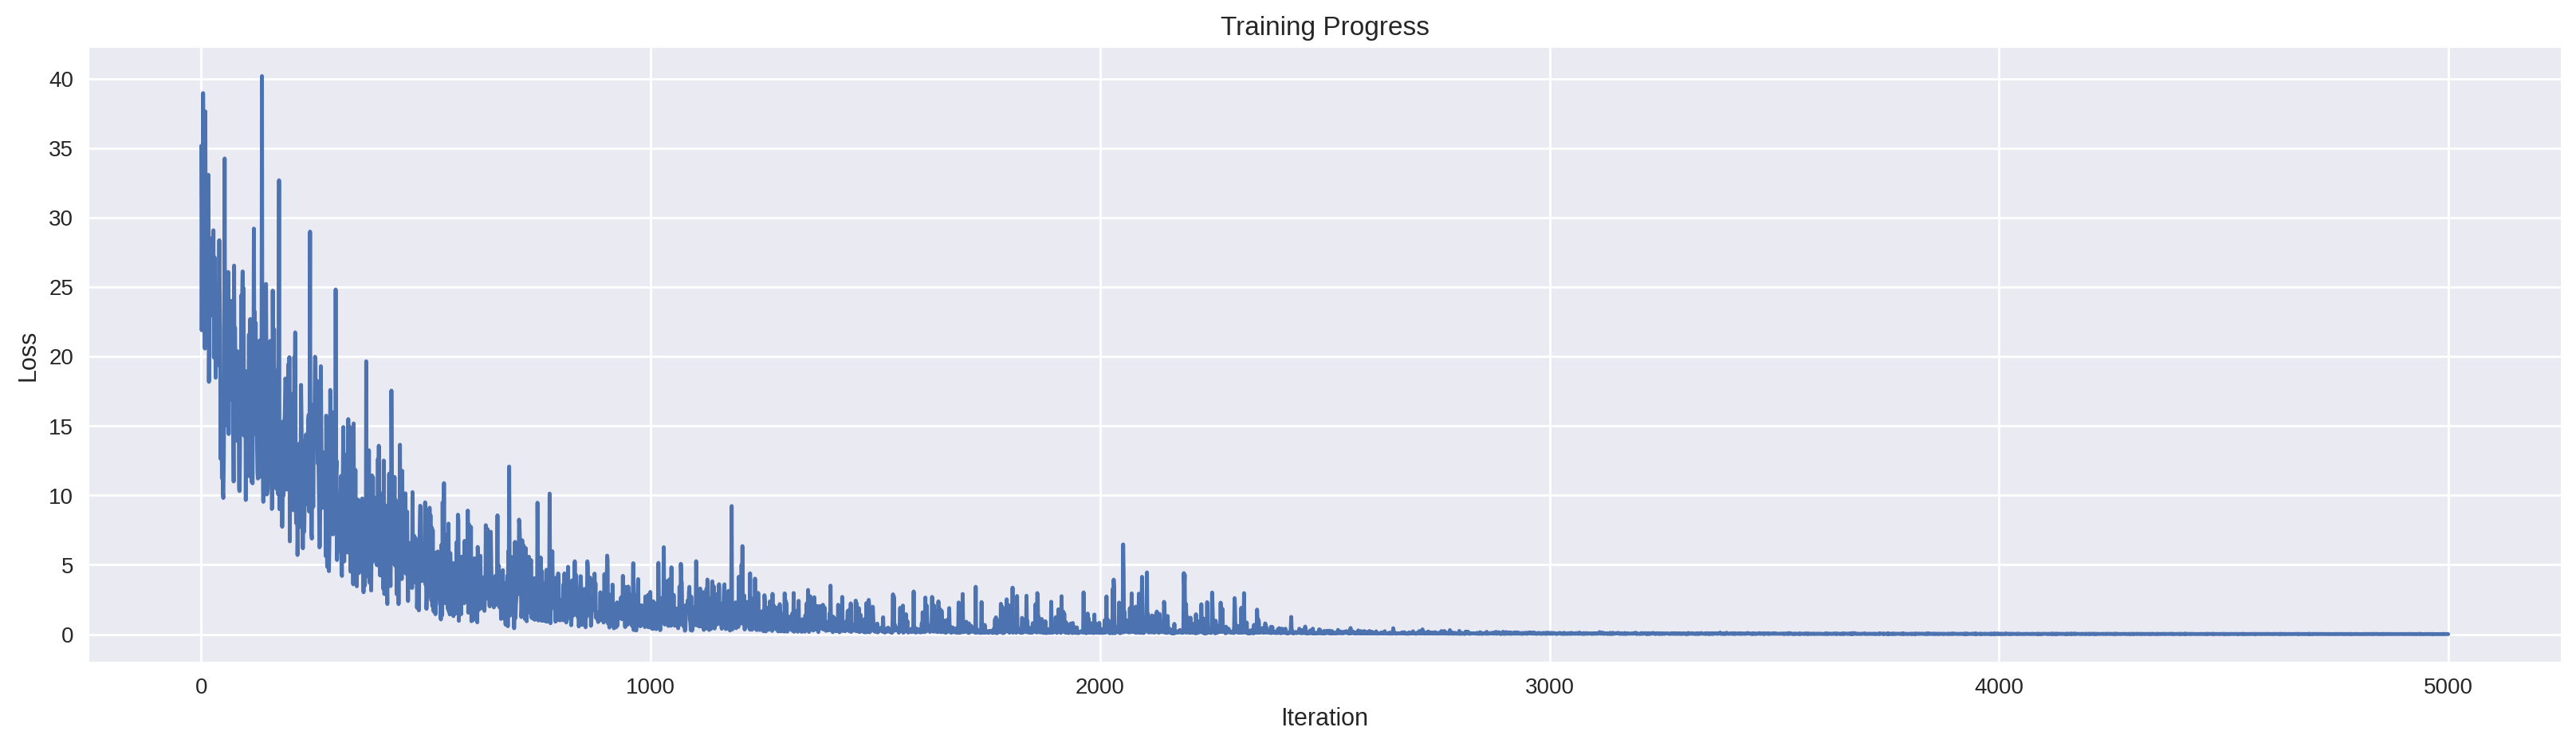

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST__

In [24]:
test_sentences = [
    "The water level was low",
    "The crow thought for a moment",
]
for sent in test_sentences:
    response, _, _ = predict(sent)
    print(f"Input:  {sent}")
    print(f"Output: {" ".join(response)}")
    print("-" * 30)

Input:  The water level was low
Output: the water was at the bottom .
------------------------------
Input:  The crow thought for a moment
Output: he saw rocks nearby .
------------------------------


### __PLOT ALIGNMENT__

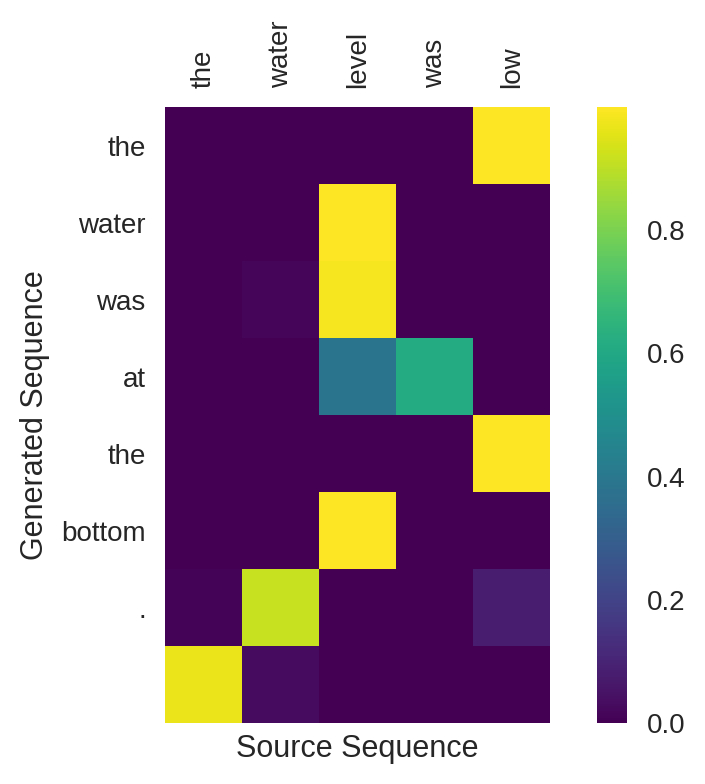

In [25]:
gen_words, attn_matrix, src_words = predict("The water level was low")
plot_attention(src_words, gen_words, attn_matrix)

## **SUMMARY: Luong vs. Bahdanau**

In this notebook, we successfully upgraded a Bahdanau Attention model to **Luong Global Attention**.

### **Key Takeaways:**
1.  **Architecture Simplification:** The decoder GRU is simpler (input size $H+E$ vs $2H+E$) because it decouples the recurrence from the attention context.
2.  **Attentional Vector:** The introduction of $\tilde{h}_t$ allows the model to explicitly combine "what I remember" ($s_t$) with "what I see" ($c_t$) before making a prediction.
3.  **General Score:** We replaced the Neural Network score (Additive) with a Matrix Multiplication score (General), which is faster and often more effective for matching vectors of the same dimension.
4.  **Xavier Initialization:** We learned that correct initialization is critical for preventing "Attention Collapse," where the model ignores the context vector.

### **References:**
* **Luong, M. T., Pham, H., & Manning, C. D. (2015).** *Effective Approaches to Attention-based Neural Machine Translation.* EMNLP.
* **Bahdanau, D., Cho, K., & Bengio, Y. (2014).** *Neural Machine Translation by Jointly Learning to Align and Translate.* ICLR.